In [1]:
import sys
sys.path.append('..')
sys.path.append('../Libraries/')
import pclpy
import ARUSTUFF
import Plane
import Corners
import cv2
import imp
import glob
import os
import numpy as np
import pcl
import open3d
import pdal
from Plane import tic,toc
import segTree
import pandas as pd

from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

WARNING (<module>): Couldn't load netifaces, some utils won't work


Load cloud

In [7]:
if False:
    for i in range(2,7):
        mm = pclpy.pcl.PointCloud.PointXYZ()
        pclpy.pcl.io.loadPCDFile('Clouds/downsampledcloudEURO'+str(i)+'.pcd',mm)
        tic()
        #miniplot
        AllGround = []
        AllNonGround = []  
        Nogroundpoints,ground = segTree.FloorRemove(mm)
        AllGround.append(ground)
        AllNonGround.append(Nogroundpoints)
        FullNonGround = [p for i in AllNonGround for p in i]
        FullGround = [p for i in AllGround for p in i]

        NongroundCloud = pclpy.pcl.PointCloud.PointXYZ(FullNonGround)
        GroundCloud = pclpy.pcl.PointCloud.PointXYZ(FullGround)

        #Corners.PCL3dpaint([NongroundCloud,GroundCloud])

        pclpy.pcl.io.savePCDFile('AllNonGroundEuro'+str(i)+'.pcd',NongroundCloud, binary_mode = True)
        pclpy.pcl.io.savePCDFile('AllGroundEuro'+str(i)+'.pcd',GroundCloud, binary_mode = True)
        print(toc())

Encontrar arboles

In [18]:
Completeness = []
Correctness = []
Mean_AoD = []
Diameter_RMSE = []
Diameter_bias = []
Location_RMSE = []
Location_bias = []

Relative_Diameter_RMSE = []
Relative_Diameter_bias = []
Relative_Location_RMSE = []
Relative_Location_bias = []

n_ref = []
n_match = []
n_extr = []
location_y = []
diameter_y = []

for filenumber in range(4,5):
    
    #Load info
    print('Load info :',filenumber)
    NongroundCloud = pclpy.pcl.PointCloud.PointXYZ()
    pclpy.pcl.io.loadPCDFile('Clouds/AllNonGroundEuro'+str(filenumber)+'.pcd',NongroundCloud)
    
    #Tree extraction
    print('Tree extraction :',filenumber)
    UseOutlier = False
    tic()
    if UseOutlier:
        goodpoints = segTree.RadiusOutlierRemoval(NongroundCloud.xyz, MinN=40, Radius=1.0, Organized=False)
    else:
        goodpoints = NongroundCloud.xyz
    print(toc())

    tic()
    cluster_list = segTree.EucladeanClusterExtract(goodpoints, tol=0.1, minc=500, maxc=6000000)
    print(toc())

    ByClusters = []
    tic()
    for i in cluster_list:
        ppclusters = segTree.RegionGrowing(i, Ksearch=20, minc=100, maxc=1000000, nn=20, smoothness=16.0, curvature=5.0)
        StemsinClusters = []
        for p in ppclusters:
            indices, model = segTree.segment_normals(p, ksearch=30, model=pcl.SACMODEL_LINE, method=pcl.SAC_RANSAC, normalweight=0.0001, miter=2000, distance=1, rlim=[0,1])
            prop = len(indices)/len(p)

            if len(indices)>1 and prop>0.2 and np.arccos(np.dot([0,0,1],model[3:6]))<.8:
                points = p[indices]
                PC,_,_ = Plane.getPrincipalComponents(points)
                if PC[0]/PC[1]>20:
                    StemsinClusters.append(points)
        if len(StemsinClusters) > 0:
            ByClusters.append(StemsinClusters)
    print(toc())

    #Group stem segments
    print('Group stem segments :',filenumber)
    composedtrees = []
    components = []
    GroupStems = []
    for i in ByClusters:
        bufferStems = i.copy()
        for n,p in enumerate(bufferStems):
            samestems = [p]
            if len(bufferStems) > 1:
                for treenumber in reversed(range(n+1,len(bufferStems))):
                    PC1 = Plane.getPrincipalComponents(p)
                    PC2 = Plane.getPrincipalComponents(bufferStems[treenumber])
                    center1 = PC1[2]
                    center2 = PC2[2]
                    angle1 = np.array(PC1[1][0])
                    angle2 = np.array(PC2[1][0])
                    if (Corners.DistPoint2Line(center1[0:3],angle2+center2[0:3],center2[0:3])<0.6) or (Corners.DistPoint2Line(center2[0:3],angle1+center1[0:3],center1[0:3])<0.6):
                        samestems.append(bufferStems[treenumber])
                        bufferStems.pop(treenumber)
            if len(samestems) > 1:
                GroupStems.append(np.array([p for i in samestems for p in i]))
            else:
                GroupStems.append(samestems[0])

    #Find Big enough stems that reach the ground
    print('Group stem segments :',filenumber)
    BigStems = [i for i in GroupStems if len(i) > 200]
    lowStems = [i for i in BigStems if np.min(i,axis=0)[2] < 3]

    #Extract cylinders
    print('Extract cylinders :',filenumber)
    finalstems = []
    stemcyls = []
    for i in lowStems:
        PC,_,_ = Plane.getPrincipalComponents(i)
        if PC[0]/PC[1]>20:
            indices, model = segTree.segment_normals(i, ksearch=20, model=pcl.SACMODEL_CYLINDER, method=pcl.SAC_RANSAC, normalweight=0.1, miter=2000, distance=0.04, rlim=[0,1])
            #Corners.PCL3dpaint([lowStems[Number],Corners.makecylinder(model=model,length=5,dense=20)])
            newmodel = model
            Z = 1
            Y = model[1] + model[4] * (Z - model[2]) / model[5]
            X = model[0] + model[3] * (Z - model[2]) / model[5]
            newmodel[0:3] = np.array([X,Y,Z])
            newmodel[3:6] = Plane.similarize(newmodel[3:6],[0,0,1])
            finalstems.append({'tree':i[indices],'model':newmodel})
            stemcyls.append(Corners.makecylinder(model=newmodel,length=5,dense=20))
            
    #Get ground truth
    print('Get ground truth :',filenumber)
    treedata = pd.read_csv('..\..\EuroSDR_DataRelease\EuroSDR_DataRelease/TLS_Benchmarking_Plot_'+str(filenumber)+'_LHD.txt',sep = '\t',names = ['x','y','height','DBH'])
    Xcor,Ycor,diam = treedata.iloc[0,[0,1,3]]
    surtreesL1 = [Corners.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=20)]
    Zcor = 0
    TreeDict = [np.array([Xcor,Ycor,Zcor])]
    for i,rows in treedata.iloc[1:].iterrows():
        Xcor,Ycor,diam = rows.iloc[[0,1,3]]
        if not np.any(np.isnan([Xcor,Ycor,diam])):
            surtreesL1.append(Corners.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/2],length=10,dense=20))
            TreeDict.append(np.array([Xcor,Ycor,diam]))
    surtrees1 = [p for i in surtreesL1 for p in i]
    surtreesCloud1 = pclpy.pcl.PointCloud.PointXYZ(surtrees1)

                #DataBase
    #Found trees
    #Hungarian Algorithm assignment
    print('Hungarian Algorithm assignment :',filenumber)
    CostMat = np.ones([len(TreeDict),len(stemcyls)])
    for X,datatree in enumerate(TreeDict):
        for Y,foundtree in enumerate(finalstems):
            CostMat[X,Y] = np.linalg.norm([datatree[0:2]-foundtree['model'][0:2]])

    dataindex, foundindex = linear_sum_assignment(CostMat,maximize=False)

    #Get metrics
    print('Get metrics: ',filenumber)
    locationerror = []
    correctlocationerror = []
    diametererror = []
    cloudmatch = []
    for i,j in zip(dataindex, foundindex):
        locationerror.append(np.linalg.norm((finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
        if locationerror[-1]<1:
            diametererror.append(abs(finalstems[j]['model'][6]*2-TreeDict[i][2]))        
            correctlocationerror.append(np.linalg.norm((finalstems[j]['model'][0:2]-TreeDict[i][0:2])))
        cloudmatch.append(np.vstack([surtreesL1[i],finalstems[j]['tree'],stemcyls[j]]))

    
    n_ref.append(len(TreeDict))
    n_match.append(len(diametererror))
    n_extr.append(len(locationerror) - n_match[-1])
    location_y.append(np.linalg.norm(np.sum(np.array([TreeDict[i][0:2] for i in dataindex]),axis=0)/len(dataindex)))
    diameter_y.append(np.sum(np.array([finalstems[i]['model'][6]*2 for i in foundindex]),axis=0)/len(foundindex))
    
    Completeness.append(n_match[-1]/n_ref[-1])
    Correctness.append(n_match[-1]/(n_extr[-1]+n_match[-1]))
    Mean_AoD.append(2*n_match[-1]/(n_ref[-1]+n_extr[-1]))
    Diameter_RMSE.append(np.sqrt(np.sum(np.array(diametererror)**2)/len(diametererror)))
    Diameter_bias.append(np.sum(np.array(diametererror))/len(diametererror))
    Location_RMSE.append(np.sqrt(np.sum(np.array(correctlocationerror)**2)/len(correctlocationerror)))
    Location_bias.append(np.sum(np.array(correctlocationerror))/len(correctlocationerror))

    Relative_Diameter_RMSE.append(Diameter_RMSE[-1]/diameter_y[-1])
    Relative_Diameter_bias.append(Diameter_bias[-1]/diameter_y[-1])
    Relative_Location_RMSE.append(Location_RMSE[-1]/location_y[-1])
    Relative_Location_bias.append(Location_bias[-1]/location_y[-1])

Load info : 4
Tree extraction : 4
0.044210000000020955
internal 15.224343299999873
internal 15.979258900000332
16.080963800000063
50.65718450000031
Group stem segments : 4
Group stem segments : 4
Extract cylinders : 4
Get ground truth : 4
Hungarian Algorithm assignment : 4
Get metrics:  4


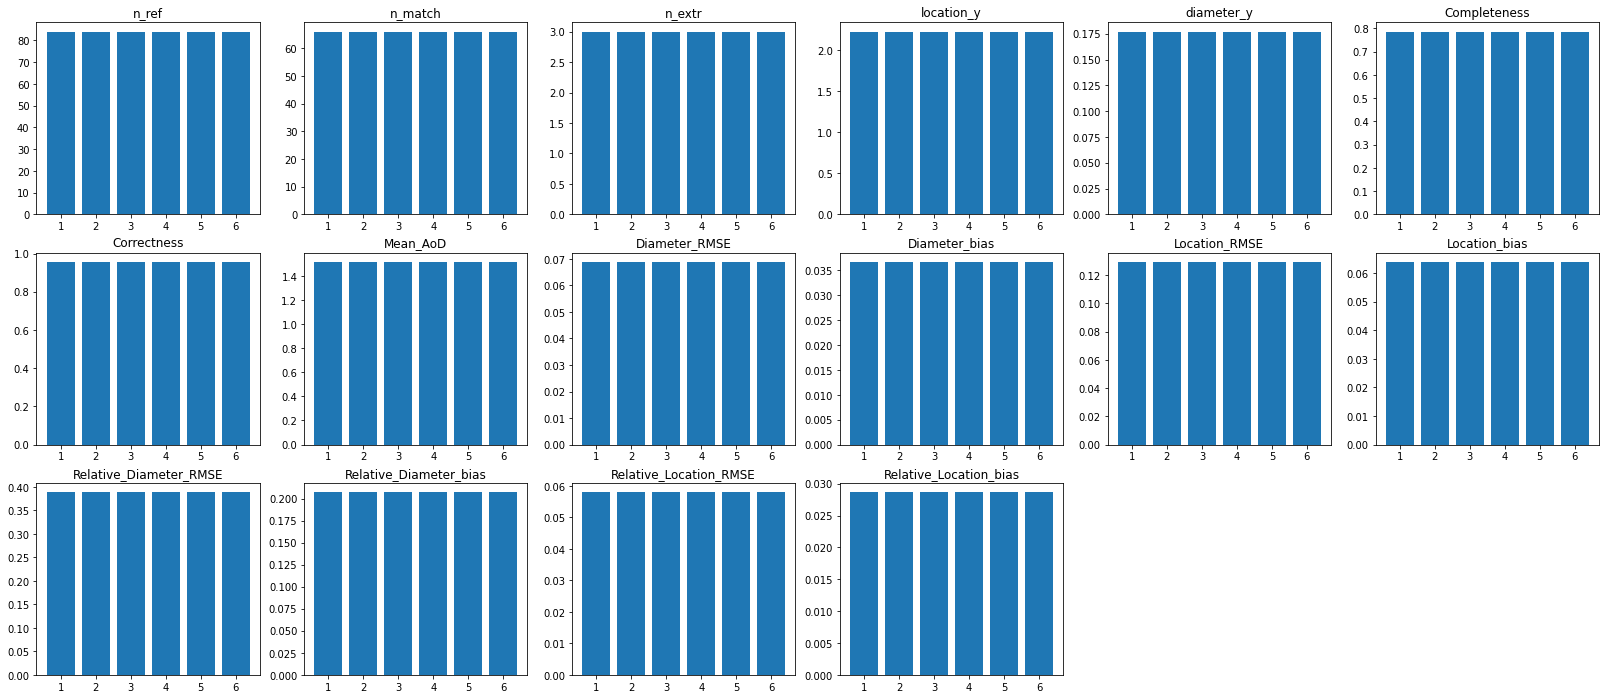

In [4]:
alldata = ['n_ref', 'n_match', 'n_extr', 'location_y', 'diameter_y', 
           'Completeness', 'Correctness', 'Mean_AoD', 'Diameter_RMSE', 'Diameter_bias', 
           'Location_RMSE', 'Location_bias', 'Relative_Diameter_RMSE', 'Relative_Diameter_bias', 'Relative_Location_RMSE', 'Relative_Location_bias']
plt.figure(figsize=(28,12))
for n,i in enumerate(alldata):
    plt.subplot(3,6,n+1)
    plt.title(i)
    plt.bar(np.array([1,2,3,4,5,6]),eval(i))

In [19]:
#Corners.PCL3dpaint(cloudmatch[0:])
Corners.PCL3dpaint([NongroundCloud]+cloudmatch[0:]+[surtrees1])

In [35]:
if False:
    np.savez('results',
             n_ref = n_ref,
             n_match = n_match,
             n_extr =n_extr,
             location_y = location_y,
             diameter_y = diameter_y, 
             Completeness = Completeness,
                    Correctness = Correctness,
                    Mean_AoD = Mean_AoD,
                    Diameter_RMSE = Diameter_RMSE,
                    Diameter_bias = Diameter_bias,
                    Location_RMSE = Location_RMSE,
                    Location_bias = Location_bias,
                    Relative_Diameter_RMSE = Relative_Diameter_RMSE,
                    Relative_Diameter_bias = Relative_Diameter_bias,
                    Relative_Location_RMSE = Relative_Location_RMSE,
                    Relative_Location_bias = Relative_Location_bias)

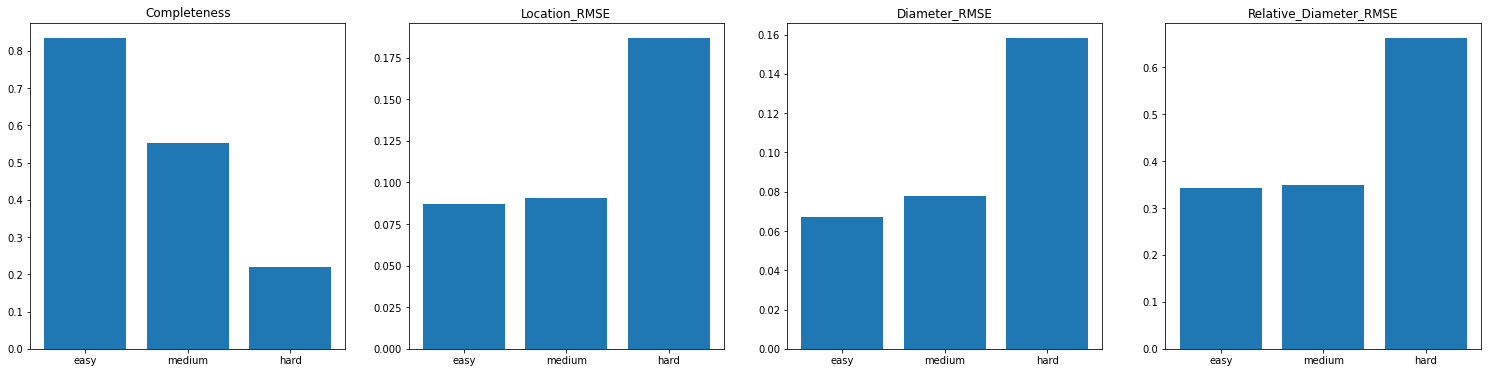

In [57]:
alldata = ['Completeness', 'Location_RMSE', 'Diameter_RMSE', 'Relative_Diameter_RMSE',]
plt.figure(figsize=(26,6))
for n,i in enumerate(alldata):
    plt.subplot(1,4,n+1)
    plt.title(i)
    avdat = [np.mean(eval(i)[slice(k,k+2)]) for k in [0,2,4]]
    plt.bar(np.array(['easy','medium','hard']),avdat)